In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import cv2
import os

import datetime
import matlab.engine

%matplotlib inline

In [19]:
def no_shift(plot_im=True):
    delta = np.zeros((5,5))
    delta[2][2] = 1
    fft_mag = np.abs(fft.fft2(delta))
    fft_arg = np.angle(fft.fft2(delta))
    
    if plot_im:
        fig, ax = plt.subplots(nrows=1, ncols=3)
        fig.tight_layout()
        ax[0].imshow(delta, cmap='gray')
        ax[0].set_title('Delta function in \n real space')

        ax[1].imshow(fft_mag,vmin=-3,vmax=3,cmap='gray')
        ax[1].set_title('Magnitude of FT of \n a delta function')

        ax[2].imshow(fft_arg,vmin=-3,vmax=3,cmap='gray')
        ax[2].set_title('Phase of FT of \n delta function')
    

def shift(plot_im=True):
    delta = np.zeros((5,5))
    delta[2][2] = 1
    delta_shifted = fft.ifftshift(delta)
    fft_mag = np.abs(fft.fft2(delta_shifted))
    fft_arg = np.angle(fft.fft2(delta_shifted))
    
    if plot_im:
        fig2, ax2 = plt.subplots(nrows=1, ncols=3)
        fig2.tight_layout()
        ax2[0].imshow(delta_shifted, cmap='gray')
        ax2[0].set_title('Delta function shifted in \n real space')

        ax2[1].imshow(fft_mag,vmin=-3,vmax=3,cmap='gray')
        ax2[1].set_title('Magnitude of FT of a \n shifted delta function')

        ax2[2].imshow(fft_arg,vmin=-3,vmax=3,cmap='gray')
        ax2[2].set_title('Phase of FT of a \n shifted delta function')

def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start
    
    init_shape = h.shape
    print("This is the Init_shape: "+str(init_shape))
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    print("This is the padded_shape: "+str(padded_shape))
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    H = fft.fft2(fft.ifftshift(hpad), norm="ortho")   #this calcualtes takes fourier transform of psf within padding
    Hadj = np.conj(H)


    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    print("This is the v: "+str(v.shape))
    pause()

    return H, Hadj, v, utils

def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

In [104]:
def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    norm2 = np.linalg.norm(diff)
    print(norm2)
    return np.real(calcAHerm(Hadj, diff, pad))

def calcA(H, vk, crop):
    Vk = fft.fft2(fft.ifftshift(vk))
    return crop(fft.fftshift(fft.ifft2(H*Vk)))

def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(fft.ifftshift(xpad))
    return fft.fftshift(fft.ifft2(Hadj*X))

def grad_descent(h, b, iters=200):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
        
    alpha = np.real(1.8/(np.max(Hadj * H)))
    iterations = 0
     
    def non_neg(xi):
        xi = np.maximum(xi,0)
        return xi
    
    #proj = lambda x:x #Do no projection
    proj = non_neg #Enforce nonnegativity at every gradient step. Comment out as needed.

    l2_error = np.zeros(iters)
    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v
    mt = 0
    
    #### uncomment for FISTA update ################
    tk = 1
    xk = v
    
    #### uncomment for ADAM update ################
#     vk = v
#     #alpha = 0.01
#     beta1 = 0.9
#     beta2 = 0.999
#     epsilon = 1e-06
#     mt = 0
#     t = 0     #time step
#     vt = np.array([0])
#     vth = np.array([0]) #np.zeros(padded_shape)
#     amsgrad = False    #set to true or false
        
    for iterations in range(iters):   

        # uncomment for ADAM update
#         vk, beta1, beta2, mt, vt, epsilon, t = adam_update(vk,beta1,beta2,mt,vt,vth,epsilon,parent_var,amsgrad,t)
    
        vk, tk, xk = fista_update(vk, tk, xk, parent_var)
        
        if iterations % 10 == 0:
            image = proj(crop(vk))
            f = plt.figure(1)
            plt.imshow(image, cmap='gray')
            plt.title('Reconstruction after iteration {}'.format(iterations))
            display.display(f)
            display.clear_output(wait=True)
    
    
    return proj(crop(vk))

def adam_update(vk, beta1, beta2, mt, vt, vth, epsilon, parent_var, amsgrad, t):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    t = t+4
    learn_rate = alpha * (np.sqrt(1-beta2**t)/(1-beta1**t))
    gradient = grad(Hadj, H, vk, b, crop, pad)
    mt1 = beta1*mt + (1-beta1)*gradient
    vt1 = beta2*vt + (1-beta2)*gradient*gradient
    #perform gradient update
    if (amsgrad == True):
    #print(type(vt))
    #print(type(vth))
    #pause()
        vth1 = np.maximum(vth,vt1)
        vk -= learn_rate*mt1/(np.sqrt(vth1)+epsilon)
        vth = vth1
    else:
        vk -= learn_rate*mt1/(np.sqrt(vt1)+epsilon)
        #vk -= learn_rate*mt1/(np.sqrt(vt1)+epsilon)
        vk = proj(vk)
        #t = t+1
        vt = vt1
        mt = mt1
    return vk, beta1, beta2, mt, vt, epsilon, t

def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    #adaptive restart momentum check
    '''grad_test = np.max(gradient*(xk-x_k1))
    if (np.mean(xk) > np.mean(x_k1)):    #grad_test > 0
      print("Im in restart loop")
      vk = xk
      xk = vk 
      tk =1
    else:
      t_k1 = (1+np.sqrt(1+4*tk**2))/2
      vk = xk+(tk-1)/t_k1*(xk - x_k1)
      tk = t_k1'''
    
    return vk, tk, xk

In [70]:
def loaddata(psf,data,dark=None,factor=8,show_im=True):
    if type(data) == str:
        with Image.open(psf) as psf_:
            psf = np.array(psf_, dtype='float32')/255
        with Image.open(data) as data_:
            data = np.array(data_, dtype='float32')/255
    
    if dark is not None:
        bg = np.mean(dark)
    else:
        bg = np.mean(psf[5:15,5:15]) 
    psf -= bg
    data -= bg
    
    """Resize to a more manageable size to do reconstruction on. 
    Because resizing is downsampling, it is subject to aliasing 
    (artifacts produced by the periodic nature of sampling). Demosaicing is an attempt
    to account for/reduce the aliasing caused. In this application, we do the simplest
    possible demosaicing algorithm: smoothing/blurring the image with a box filter"""

    psf_internal = internal_resize(psf.copy(),factor)
    data_internal = internal_resize(data.copy(),factor)
    
    del psf, data
    
    psf = psf_internal
    data = data_internal
    
    """Now we normalize the images so they have the same total power. Technically not a
    necessary step, but the optimal hyperparameters are a function of the total power in 
    the PSF (among other things), so it makes sense to standardize it"""
    
    psf /= np.linalg.norm(psf.ravel())
    data /= np.linalg.norm(data.ravel())
    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')
        display.display(fig1)
        fig2 = plt.figure()
        plt.imshow(data, cmap='gray')
        plt.title('Raw data')
        display.display(fig2)
    return psf, data

def internal_resize(img, factor):
    #factor = int(np.log2(factor))
    width = int(img.shape[0]/factor)
    height = int(img.shape[1]/factor)
    out_dim = (height,width)
    img_out = cv2.resize(img,out_dim, interpolation = cv2.INTER_LANCZOS4)
    print(img_out.shape)
    return img_out



In [75]:
class diffuseCAM(object):
    
    def __init__(self,cam_idx=0,window_name='diffuseCAM',**kwargs):
        self.window_name = window_name
        self.sess = str(datetime.datetime.now()).replace(':','-')
        self.cam_idx=cam_idx
        super(diffuseCAM,self).__init__(**kwargs)
    
    def preview(self):
        self.start()
        if self.cam.isOpened(): # try to get the first frame
            rval, frame = self.cam.read()
        else:
            rval = False
        while rval:
            cv2.imshow(self.window_name, frame)
            rval, frame = self.cam.read()
            keypress = cv2.waitKey(20)
            if keypress == 27: # exit on ESC
                break
            elif keypress == ord('q'):
                frame = self.BGR2RGB(frame)
                plt.figure()
                plt.hist(frame.ravel())
#                 self.imsave(frame,'unsorted')
        self.close()
        
    def close(self):
        cv2.destroyWindow(self.window_name)
        self.cam.release()
        
    def start(self):
        cv2.namedWindow(self.window_name)
        self.cam = cv2.VideoCapture(self.cam_idx)
        if not self.cam.isOpened():
            raise RuntimeError('Could not start camera')
    
    def capture(self,folder='unsorted'):
        self.start()
        _, frame = self.cam.read()
        self.close()
        frame = self.BGR2RGB(frame)
        self.imsave(frame,folder)
        return frame
    
    def BGR2RGB(self,frame):
        frame = [frame[:,:,2],frame[:,:,1],frame[:,:,0]]
        return np.asarray(np.swapaxes(np.swapaxes(frame,0,2),0,1),dtype=np.float32)/255
    
    def calibrate_dark(self,num_frames=10):
        self.start()
        _, img = self.cam.read()
        img = self.BGR2RGB(img)
        for idx in range(num_frames-1):
            _, frame = self.cam.read()
            frame = self.BGR2RGB(frame)
            img += frame
        self.dark = img/num_frames
        self.close()
        
    def calibrate_psf(self,num_frames=5):
        self.start()
        _, img = self.cam.read()
        img = self.BGR2RGB(img)
        for idx in range(num_frames-1):
            _, frame = self.cam.read()
            frame = self.BGR2RGB(frame)
            img += frame
        self.psf = img/num_frames
        self.imsave(frame,'psf')
        self.close()
        
    def imsave(self,img,folder):
        time_now = self.sess = str(datetime.datetime.now()).replace(':','-')
        plt.imsave('../data/%s/dc_%s.png'%(folder,time_now),img)
        
dC = diffuseCAM(1)

In [23]:
def pause():
    programPause = input("Press the <ENTER> key to continue...")

In [15]:
eng = matlab.engine.start_matlab()
def rgb2gray(img,eng=None):
    if eng is not None:
        img = eng.rgb2gray(matlab.double(np.ndarray.tolist(img)))
    else:
        img = 0.2989 * img[:,:,0] + 0.5870 * img[:,:,1] + 0.1140 * img[:,:,2]
    return img

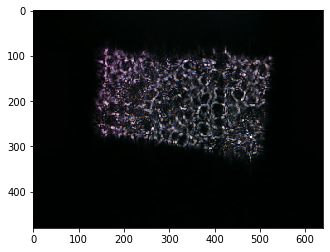

In [77]:
dC.calibrate_dark()
plt.imshow(dC.dark)

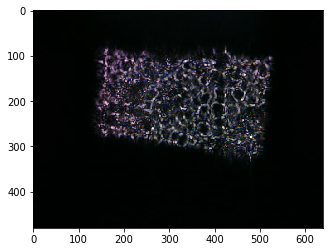

In [78]:
dC.calibrate_psf()
plt.imshow(dC.psf)

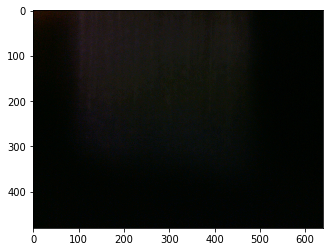

In [52]:
img = dC.capture()
plt.imshow(img)

In [113]:
dC.preview()

In [ ]:
psf = '../data/psf_sample.tif'
data = '../data/rawdata_hand_sample.tif'
iters = 200

In [ ]:
psf, data = loaddata(psf,data,factor=8)
final_im = grad_descent(psf, data,iters)
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstruction after {} iterations'.format(iters))
display.display()

#plt.savefig('final_img.pdf')

0.061277276537108585
0.06127391969077214
0.06127061188372315
0.06126735772329989
0.061264189252457794
0.06126104934427865
0.06125793045670316
0.061254847100254264
0.06125179313974467


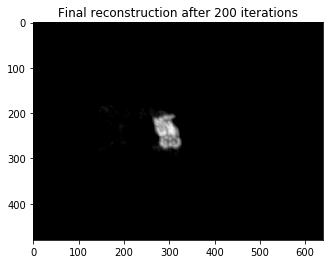

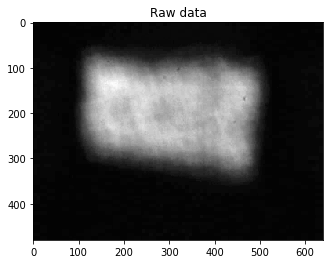

In [114]:
iters = 200
psf, data = loaddata(rgb2gray(dC.psf),
                     rgb2gray(dC.capture('raw_data')),
#                      rgb2gray(dC.dark),
                     factor=1)
final_im = grad_descent(psf,data,iters)
plt.imshow(final_im, cmap='gray')
dC.imsave(final_im,'reconstructed')
plt.title('Final reconstruction after {} iterations'.format(iters))
display.display()

#plt.savefig('final_img.pdf')

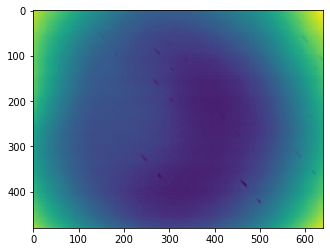

In [16]:
plt.imshow(rgb2gray(dC.psf))